# PageRank - A numpy / Jupyter / matplotlib example

In this Jupyter notebook we consider Google's PageRank computation. Nodes correspond to webpages and edges to links from one webpage to another webpage. We consider a very simple graph with only six _nodes_ and where every node has one or two outgoing _edges_. The original description of the PageRank computation can be found in the paper below that contains an overview of the original infrastructure of the Google search engine.

* Sergey Brin and Lawrence Page.
  _The Anatomy of a Large-Scale Hypertextual Web Search Engine_.
  Seventh International World-Wide Web Conference (WWW 1998), April 14-18, 1998, Brisbane, Australia.
  [http://ilpubs.stanford.edu:8090/361/]
  
<img src="pagerank.png" height="300" width="300">

## Random surfer (simplified)
The PageRank of a node (web page) is the ratio of the time one visits a node by performing an _infinite random traversal_ of a graph where one starts in node 1, and in each step performs:

 * with probability 1/6 jumps to a random page (probability 1/6 for each node)
 * with probability 5/6 follows an outgoing edge to an adjacent node (selected uniformly)
 
The above can be simulated by using a dice: Roll a dice. If it shows 6, jump to a random page by rolling the dice again to figure out which node to jump to. If the dice shows 1-5, follow an outgoing edge - if two outgoing edges roll the dice again and go to the lower number neighbor if it is odd.

## Graph represenation - _adjacency matrix_

In [22]:
import numpy as np

# Adjacency matrix of the above directed graph 
# (note that the rows/colums are 0-indexed, whereas in the figure the nodes are 1-indexed)

G = np.array([[0, 1, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [1, 1, 0, 0, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 1, 0, 0, 0, 1],
              [0, 1, 0, 0, 0, 0]])

n = G.shape[0]  # number of rows in G

degree = np.sum(G, axis=1, keepdims=True)  # column vector with row sums = out-degrees

# The below code handles sinks, i.e. nodes with outdegree zero
# this has no effect on the graph above, since no sinks

G = G + (degree == 0)  # add edges from sinks to all nodes 
degree = np.sum(G, axis=1, keepdims=True)

print(G)

[[0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [1 1 0 0 0 0]
 [0 1 0 0 1 0]
 [0 1 0 0 0 1]
 [0 1 0 0 0 0]]


## Simulate random walk (random surfer model)

In [27]:
from random import randint

STEPS = 1000000

# adjacency_list[i] is a list of all j where (i, j) is an edge of the graph.
adjacency_list = [[j for j, e in enumerate(row) if e] for row in G]

count = np.zeros(n)         # histogram over number of node visits
state = 0                   # start at node with index 0
for _ in range(STEPS):
    count[state] += 1       # increment count for state
    if randint(1, 6) == 6:  # original paper uses 15% instead of 1/6
        state = randint(0, 5)
    else:
        state = adjacency_list[state][randint(0, degree[state] - 1)]

print(adjacency_list, count / STEPS, sep='\n')

[[1], [3], [0, 1], [1, 4], [1, 5], [1]]
[0.039108 0.353342 0.027621 0.322408 0.162235 0.095286]


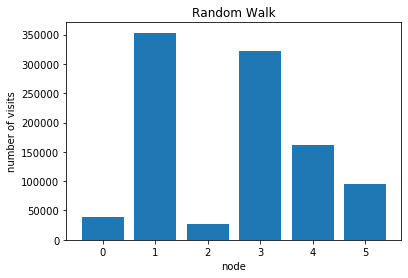

In [3]:
# To make matploblib figures interactive replace 'inline' by 'notebook'
%matplotlib inline

import matplotlib.pyplot as plt

plt.bar(range(6), count)

plt.title("Random Walk")
plt.xlabel("node")
plt.ylabel("number of visits")
plt.show()

## Transition matrix

In [4]:
A = G / degree  # Normalize row-sums to one. Note that 'degree' 
                # is a n x 1 matrix, whereas G is an n x n matrix.
                # The elementwise division is repeated for each column of G.
       
print(A)

[[0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0. ]
 [0.5 0.5 0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.5 0. ]
 [0.  0.5 0.  0.  0.  0.5]
 [0.  1.  0.  0.  0.  0. ]]


## Computation of transition matrix

We now want to compute the probability $p^{(0)}_j$ to be in vertex $j$ after $i$ steps. Initially we have $p^{(0)}_0=1$ and $p^{(0)}_j=0$ for $j\neq 0$. Let $p^{(i)}=(p^{(i)}_0,\ldots,p^{(i)}_{n-1})$, i.e. $p^{(0)} = (1,0,\ldots,0)$. We compute a matrix $M$, such that $p^{(i)} = M^i p$ (assuming p is a column vector). If we let $\textbf{1}_n$ denote the $n\times n$ matrix with one in each entry, then $M$ can be computed as:

$$p^{(i+1)}_j = \frac{1}{6} \cdot \frac{1}{n} + \frac{5}{6} \sum_k p^{(i)}_{k} \cdot A_{k, j}$$

$$p^{(i+1)} = M \cdot p^{(i)}$$

$$M = \frac{1}{6}\cdot\frac{1}{n}\textbf{1}_n + \frac{5}{6} A^\mathrm{T}$$

In [5]:
ITERATIONS = 20

p_0 = np.zeros((n, 1))
p_0[0, 0] = 1.0

M = 1 / (6 * n) + 5 / 6 * A.T 

p = p_0
prob = p  # 'prob' will contain each computed 'p' as a new column

for _ in range(ITERATIONS):
    p = M @ p
    prob = np.append(prob, p, axis=1)
  
print(p)

[[0.03935185]
 [0.35326184]
 [0.02777778]
 [0.32230071]
 [0.16198059]
 [0.09532722]]


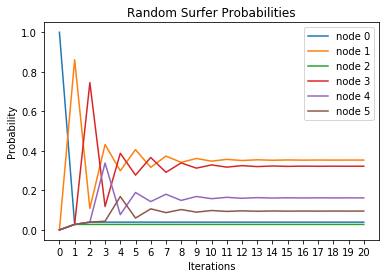

In [6]:
%matplotlib inline

x = range(ITERATIONS + 1)
for node in range(n):
    plt.plot(x, prob[node], label="node %s" % node)

plt.xticks(x)
plt.title("Random Surfer Probabilities")
plt.xlabel("Iterations")
plt.ylabel("Probability")
plt.legend()
plt.show()

## Repeated squaring
Exploiting that for $k$ being a power of two, 
$$M \cdot (M \cdots (M \cdot (M \cdot p_\mathrm{init}))) 
= M^k \cdot p_\mathrm{init}
= M^{2^{\log k}} \cdot p_\mathrm{init}
= (\cdots(((M^2)^2)^2)\cdots)^2 \cdot p_\mathrm{init}$$ 
we can compute the PageRank vector with a reduced number of matrix multiplications.

In [18]:
from math import ceil, log

MP = M
for _ in range(1 + int(log(ITERATIONS, 2))):
    MP = MP @ MP
    
p = MP @ p_0 

print(p)

[[0.03935185]
 [0.35332637]
 [0.02777778]
 [0.32221711]
 [0.16203446]
 [0.09529243]]


## Computing eigen vector

We want to find the vector $p$ where $M p = p$, i.e. we want to find an _eigen vector_ $p$ for the _eigen value_ $\lambda=1$, where $|p|=1$.

In [8]:
eigenvalues, eigenvectors = np.linalg.eig(M)

#print("eigenvalues =", eigenvalues)
#print("eigenvectors =", eigenvectors)
idx = eigenvalues.argmax()  # find the largest eigen value (= 1)
p =  np.real(eigenvectors[:, idx])  # .real returns the real part of complex numbers
p /= p.sum()  # normalize p to have sum 1

print(p)

[0.03935185 0.3533267  0.02777778 0.32221669 0.16203473 0.09529225]


## Note on practicality
In practice an explicit matrix for billions of nodes is infeassable, since the number of entries would be order of $10^{18}$. Instead one has to work with sparse matrices (in Python modul <tt>scipy.sparse</tt>) and stay with repeated multiplication.

## Time considerations

You can arrive at the same results in many ways, but some are more efficient than others. In the example below a matrix is created with all values equal to 1/n in two different ways:

  * First 1 / n is computed, and then filled into all entries of a new matrix.
  * First a matrix is construct containing 1 in each entry, and then all entries are divided by the value n. 

In [9]:
%%timeit
np.full((n, n), 1 / n)  # n x n matrix with 1/n in all entries

2.59 µs ± 154 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%%timeit
np.ones((n, n)) / n  # same as above, just slower

3.86 µs ± 187 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
